# 3.1.4 Model Comparison

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import math

In [22]:
path = ("/Users/gemma/Documents/data science/DS bootcamp/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df = pd.read_csv(path, delimiter= ',', encoding='latin-1',header=0)


In [23]:
# getting names of columns to access them more easily
# and renaming murder because the name is messy

colnames = df.columns.values
print(colnames)


['City' 'Population' 'Violent\ncrime'
 'Murder and\nnonnegligent\nmanslaughter' 'Rape\n(revised\ndefinition)1'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3']


In [24]:
# adding binary features - murder (or robbery) > 0 = 1, else 0

df['Murder bin'] = np.where(df[colnames[3]]==0, 0, 1)
df['Robbery bin'] = np.where(df['Robbery'] == 0, 0, 1)
df['Aggravated asault bin'] = np.where(df['Aggravated\nassault'] == 0,0,1)

In [25]:
# making the data frame i'll use for the OLS regression

crime = df.drop(labels=colnames[2:8], axis=1)
crime.drop(labels=colnames[10:13], axis=1, inplace=True)

In [26]:
# renaming the weirdly named columns

crime.rename({'Murder bin': 'Murder', 'Robbery bin':'Robbery', 
              'Property\ncrime': 'Propertycrime', 'Aggravated asault bin': 'A. assault'}, axis='columns',inplace=True)


In [27]:
# cleaning up population and property crime 

num_cleanup = ['Population', 'Propertycrime','Burglary'] 

# there's at least one cell (in Population) with just a space, so filling blanks with NaN
crime = crime.replace(r'^\s*$', np.nan, regex=True)

# now dropping the row(s) that contain(s) the nan 
crime.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

    # finally! the series is an integer (checked in the cell below)
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup:
    cleanup(crime, one)

# double checking
crime.dtypes


City             object
Population        int64
Propertycrime     int64
Burglary          int64
Murder            int64
Robbery           int64
A. assault        int64
dtype: object

In [28]:
# adding pop ^2 bc i didnt do that yet

crime.insert(2, 'Popˆ2', crime['Population']**2, allow_duplicates=False)

In [29]:
crime.head(3)

,City,Population,Popˆ2,Propertycrime,Burglary,Murder,Robbery,A. assault
0,Adams Village,1861,3463321,12,2,0,1,1
1,Addison Town and Village,2577,6640929,24,3,0,1,1
2,Akron Village,2846,8099716,16,1,0,1,1


# OLS Regression

In [31]:
# holdout groups

data = crime[['Population','Popˆ2','Murder','Robbery','Burglary']]
target = crime['Propertycrime'] 

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)

regr = linear_model.LinearRegression()

print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: -432.9860601786066
Testing on Sample: 0.999576580943301


A first attempt at the OLS model shows a very mixed r squared value with 20% holdout. 

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, data, target, cv=10)



array([   0.938554  ,    0.98519169,    0.84341985,    0.89958785,
          0.89559403,    0.93098549, -299.41182903,    0.99072378,
          0.99333016,    0.79445254])

Additionally, I cross validated the model. Overall, they values within a reasonable range of each other, with the exception of one outlier. It appears like this may be due to an outlier in the data, and some features that are not linear. 

Below, I removed the outlier and tried to transform the data in order to improve the model's accuracy.

In [34]:
# looks like there's an outlier skewing the results

max(crime['Propertycrime'].unique().tolist())

# finding where the outlier is

crime[crime['Propertycrime'] == 141971]

# dropping it

crime.drop([216], inplace=True)

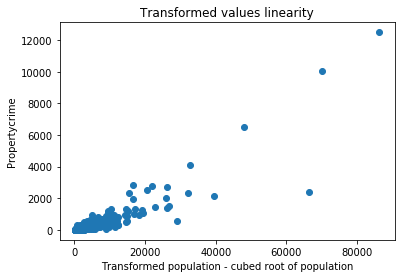

In [35]:
def my2ndform(value):
    return value**1/3
    

crime['cubeRTpop'] = crime['Population'].apply(my2ndform)

plt.scatter(crime['cubeRTpop'],  crime['Propertycrime'].values.reshape(-1, 1))
plt.title('Transformed values linearity')
plt.xlabel('Transformed population - cubed root of population')
plt.ylabel('Propertycrime')
plt.show()

Applying the transformation to the population (using the cubed root of the population and removing the outlier) was an attempt to make the data linear, in order to best suit the OLS model. It appears like getting the cubed root of the population was successful in making the data linear.

In [36]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [37]:
linear_formula4 = 'Propertycrime ~ cubeRTpop+Burglary'

lm5 = smf.ols(formula=linear_formula4, data=crime).fit()

print('Parameters \n\n{}'.format(lm5.params))
print('\n\nP values \n\n{}'.format(lm5.pvalues))
print('\nR Squared\n\n{}'.format(lm5.rsquared))

lm5.conf_int()

Parameters 

Intercept    10.491039
cubeRTpop     0.030296
Burglary      2.966738
dtype: float64


P values 

Intercept     3.116635e-01
cubeRTpop     3.876539e-53
Burglary     2.728687e-167
dtype: float64

R Squared

0.9767013450346452


,0,1
Intercept,-9.874231,30.856309
cubeRTpop,0.027058,0.033534
Burglary,2.856416,3.077061


After rerunning the model, it looks like the p values, coefficients, and the r squared value are all improved. The table, which shows the confidence intervals, is also very good becasue the values in 0 and 1 do not cross zero and are a small range.

In [38]:
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Propertycrime   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     7210.
Date:                Mon, 07 May 2018   Prob (F-statistic):          1.52e-281
Time:                        20:07:16   Log-Likelihood:                -2248.3
No. Observations:                 347   AIC:                             4503.
Df Residuals:                     344   BIC:                             4514.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4910     10.354      1.013      0.312      -9.874      30.856
cubeRTpop      0.0303      0.002     18.403      0.000       0.027       0.034
Burglary       2.9667      0.056     52.893      0.000       2.856       3.077
==============================================================================
Omnibus:                      140.960   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3011.306
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                      17.249   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A summary shows that the revised OLS model seems to be pretty accurate. Below, I just check one last time with the 20% holdout.

In [49]:
data_2 = crime[['cubeRTpop', 'Population', 'Murder','Burglary']]
target_2 = crime['Propertycrime'] 

# Use train_test_split to create the necessary training and test groups
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(data, target, test_size=0.2, random_state=20)

regr = linear_model.LinearRegression()

print('With 20% Holdout: ' + str(regr.fit(X_2_train, y_2_train).score(X_2_test, y_2_test)))
print('Testing on Sample: ' + str(regr.fit(data_2, target_2).score(data_2, target_2)))

With 20% Holdout: -432.9860601786066
Testing on Sample: 0.9767380600873643


# K Nearest Neighbors Regression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


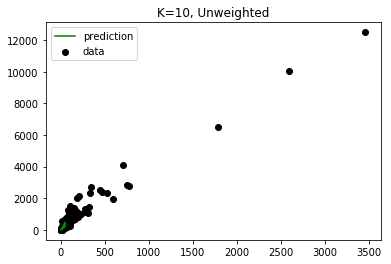

In [42]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = crime['Burglary'].reshape(-1, 1)
Y = crime['Propertycrime']
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

The initital K Nearest Neighbors model used only the "Burglary feature". Above it shows the prediction line and the actual data points.

In [44]:
score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# w/ holdout groups
target2 = Y
data2 = X

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=20)

print('\nWith 20% Holdout: ' + str(knn.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(knn.fit(data2, target2).score(data2, target2)))

Weighted Accuracy: 0.76 (+/- 0.14)

With 20% Holdout: 0.8477538776093082
Testing on Sample: 0.9951617776684435


Using this first K Nearest Neihbors, the weighted accuracy was lower than that of the OLS regression, but using hte 20% holdout the accuracy was quite high.

In [45]:
from sklearn import neighbors

# Build our model.
knn2 = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X2 = crime[['Burglary', 'cubeRTpop']]
Y2 = crime['Propertycrime']
knn2.fit(X2, Y2)

score2 = cross_val_score(knn2, X2, Y2, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))

# w/ holdout groups
target3 = Y2
data3 = X2

X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=20)

print('\nWith 20% Holdout: ' + str(knn.fit(X_train3, y_train3).score(X_test3, y_test3)))
print('Testing on Sample: ' + str(knn.fit(data3, target3).score(data3, target3)))

Weighted Accuracy: 0.59 (+/- 0.23)

With 20% Holdout: 0.820983503890574
Testing on Sample: 1.0


It appears like adding in the second feature, the cubed root of Population, further decreases the accuracy of the model, which appears to be highly overfitted to the data.

## Model comparison

<em>At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.</em>